In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import uuid

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Input

In [4]:
# Avoid OOM erros by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# MAke the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [51]:
# Uncompress Tar GZ labelled Faces in the wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [44]:
# Establish a connection to the Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250*250px
    frame = frame[50:50+250,250:250+250,:]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect Positive gracefully
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow("Image Collection", frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Webcam release
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [5]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)

    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

In [8]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img), label)

In [11]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [12]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [13]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [14]:
def make_embedding():
    inp = Input(shape=(105,105,3), name="input_image")

    # First block
    c1 = Conv2D(64, (10,10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    # Final block
    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [15]:
embedding = make_embedding()

In [16]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [17]:
# Siamese L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
def make_siamese_model():

    # Handle inputs
    input_image = Input(name="input_img", shape=(105,105,3))
    validation_image = Input(name="validation_img", shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [19]:
siamese_model = make_siamese_model()

In [20]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [21]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [22]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [23]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [24]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

In [28]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [32]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(f"Loss: {loss.numpy()} Recall: {r.result().numpy()} Precision: {p.result().numpy()}")

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
EPOCHS = 50

In [34]:
train(train_data,EPOCHS)


 Epoch 1/50
27/27 [==============================] - 19s 685ms/step
Loss: 0.01118121575564146 Recall: 0.9722222089767456 Precision: 0.8677685856819153

 Epoch 2/50
27/27 [==============================] - 17s 633ms/step
Loss: 0.019725194200873375 Recall: 0.9906542301177979 Precision: 0.9724770784378052

 Epoch 3/50
27/27 [==============================] - 17s 627ms/step
Loss: 0.00022631110914517194 Recall: 0.9907407164573669 Precision: 0.9953488111495972

 Epoch 4/50
27/27 [==============================] - 17s 628ms/step
Loss: 0.0018900223076343536 Recall: 0.9854369163513184 Precision: 0.9806763529777527

 Epoch 5/50
27/27 [==============================] - 15s 558ms/step
Loss: 0.0019226382719352841 Recall: 1.0 Precision: 0.9952606558799744

 Epoch 6/50
27/27 [==============================] - 14s 525ms/step
Loss: 0.00028789619682356715 Recall: 1.0 Precision: 0.9955157041549683

 Epoch 7/50
27/27 [==============================] - 14s 527ms/step
Loss: 0.00038411308196373284 Recall: 1

In [43]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [36]:
# Make predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 26ms/step


array([[9.9999082e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5721434e-09],
       [4.6295911e-05],
       [1.9019751e-07],
       [9.9999976e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.8805609e-11],
       [9.9999952e-01],
       [9.9999905e-01],
       [1.2834388e-05],
       [9.9999952e-01],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [37]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]

In [38]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [39]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [41]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(f"Recall: {r.result().numpy()} Precision: {p.result().numpy()}")


1/1 [==============================] - 0s 22ms/step
Recall: 1.0 Precision: 1.0


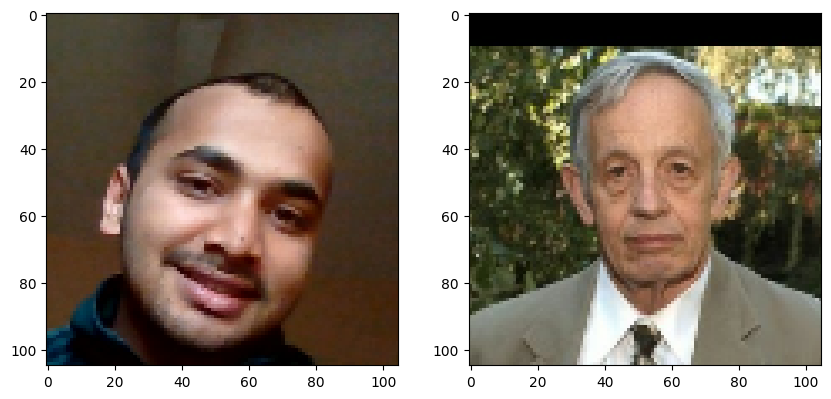

In [44]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[8])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()

In [79]:
# Save weights
siamese_model.save("siamesemodelV2.h5")

In [81]:
# Reload model
# model = tf.keras.models.load_model("siamesemodel.h5", compile=False)
model = tf.keras.models.load_model("siamesemodel.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [82]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 153ms/step


array([[9.9999857e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9986923e-01],
       [9.9971360e-01],
       [8.6338942e-10],
       [1.0000000e+00],
       [2.0659741e-10],
       [1.2647493e-09],
       [6.9860015e-08],
       [5.9333320e-08],
       [1.0000000e+00],
       [9.9999881e-01],
       [5.1526927e-10],
       [9.9996126e-01],
       [1.0000000e+00]], dtype=float32)

In [83]:
def verify( model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join("application_data","verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

     # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold
    
    return results, verified

In [84]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250*250px
    frame = frame[50:50+250,250:250+250,:]

    cv2.imshow("Verification", frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 23ms/step
True
1/1 [==============================] - 0s 25ms/step
False


array([7.1083150e-08, 8.5673173e-06, 2.7601749e-07, 2.3087829e-07,
       3.7118664e-06, 3.1935472e-06, 1.9918725e-06, 3.2733718e-07,
       4.3963855e-09, 2.6355387e-06, 3.6189809e-10, 3.4197009e-07,
       7.1246813e-09, 2.9690941e-11, 1.3969405e-10, 3.7641237e-09,
       5.7165911e-10, 1.5631121e-10, 2.1268279e-10, 4.0981416e-08,
       2.8135347e-10, 1.8733820e-10, 1.3736889e-10, 1.2507247e-10,
       1.1022522e-10, 6.8628235e-11, 3.0063080e-07, 9.2532448e-10,
       9.9847353e-12, 8.5792255e-11, 2.7015318e-10, 2.6257969e-03,
       1.3950633e-02, 3.6295427e-05, 6.4250271e-05, 2.4660947e-03,
       9.7660564e-09, 9.8329804e-07, 1.7603112e-05, 1.0296840e-04,
       7.0620371e-10, 1.4481296e-07, 3.7381648e-07, 1.2919398e-04,
       8.9156551e-08, 4.6839732e-09, 1.8369302e-10, 3.7751507e-10,
       6.6595192e-08, 5.2477335e-05], dtype=float32)